# Notebook for the project in *TDT4259 - Applied Data Science*

Necessary imports

In [13]:
import sys
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")
sys.path.append(".")

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

from dmba import plotDecisionTree

from util.figures import plot_attrtion_by_group_count
from util.model_utils import train_test_model
from util.dataset_manipulation import get_and_process_df

FIG_PATH = Path.cwd().joinpath("figures")

We start by preprocessing the columns to be on a concise format.

In [14]:
dataset = get_and_process_df("train_data.csv")
desc_dataset = get_and_process_df("train_data.csv", False)

## Creating some descriptive statistics

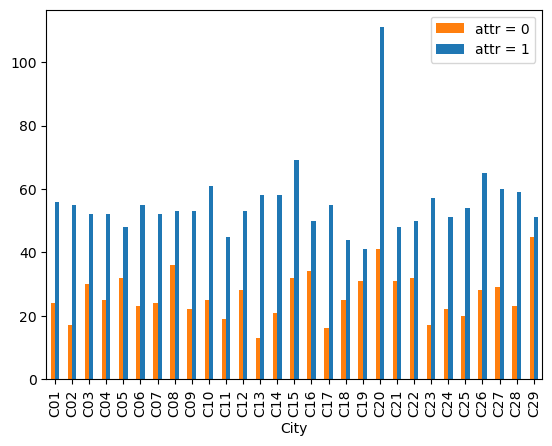

In [15]:
plot_attrtion_by_group_count(desc_dataset, "City", relative = False, stacked = False, col_labels = False)

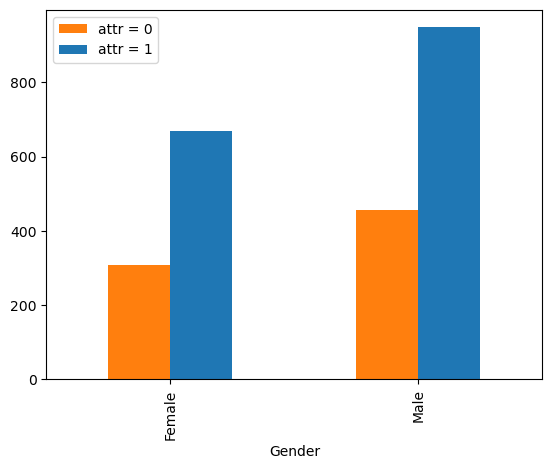

In [16]:
plot_attrtion_by_group_count(desc_dataset, "Gender", relative = False, stacked = False, col_labels = False)

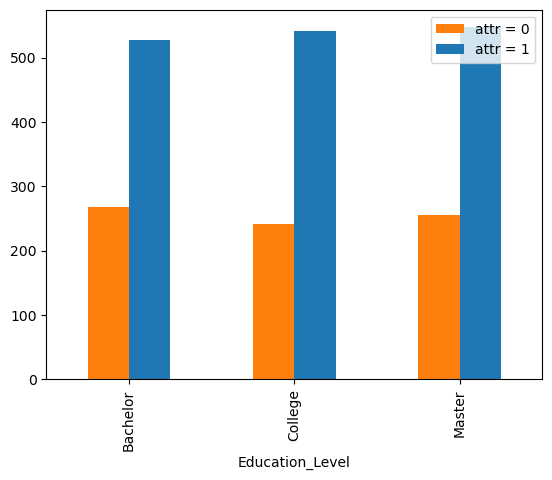

In [17]:
plot_attrtion_by_group_count(desc_dataset, "Education_Level", relative = False, stacked = False, col_labels = False)

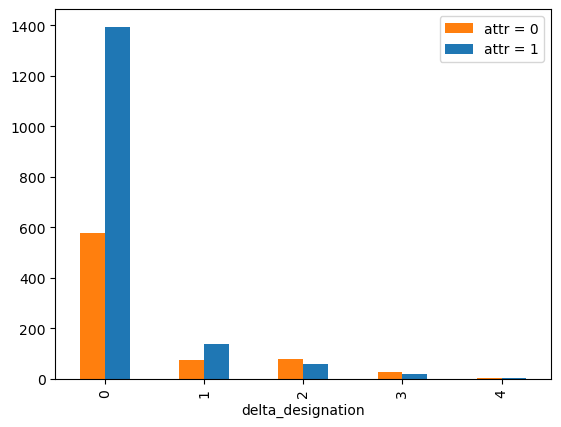

In [18]:
plot_attrtion_by_group_count(desc_dataset, "delta_designation", relative = False, stacked = False, col_labels = False)

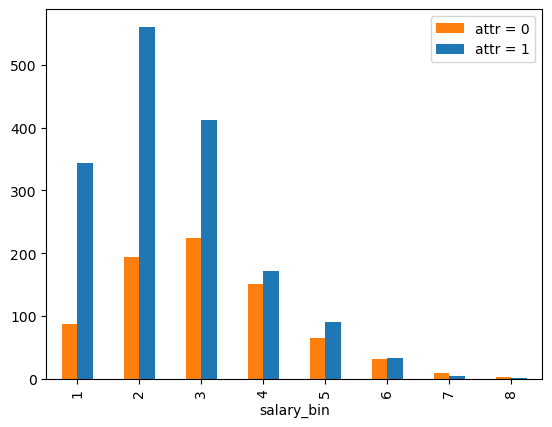

In [19]:
plot_attrtion_by_group_count(desc_dataset, "salary_bin", relative = False, stacked = False, col_labels = False)

# Prototyping some classifications

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = dataset.drop(columns = ["Date", 
                            "Attrition", 
                            "Emp_ID", 
                            "Date_Of_Joining", 
                            "Last_Working_Date", 
                            "Joining_Designation", 
                            "Designation",
                            "Total_Business_Value",
                            # "Work_Duration",
                            # "Salary"
                            "salary_bin"
                            ]
                            )
y = dataset["Attrition"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = 4259)

## Using a Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

0.7253668763102725
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       153
           1       0.81      0.78      0.79       324

    accuracy                           0.73       477
   macro avg       0.69      0.70      0.69       477
weighted avg       0.73      0.73      0.73       477

[[ 94  59]
 [ 72 252]]


In [24]:
from sklearn.model_selection import GridSearchCV
'''
# Start with an initial guess for parameters
param_grid = {
'max_depth': [10, 20, 30, 40],
'min_samples_split': [20, 40, 60, 80, 100],
'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
'criterion': ["gini", "entropy"]
}
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)
'''

'\n# Start with an initial guess for parameters\nparam_grid = {\n\'max_depth\': [10, 20, 30, 40],\n\'min_samples_split\': [20, 40, 60, 80, 100],\n\'min_impurity_decrease\': [0, 0.0005, 0.001, 0.005, 0.01],\n\'criterion\': ["gini", "entropy"]\n}\n# Which values are best?\n# n_jobs=-1 will utilize all available CPUs\ngridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)\ngridSearch.fit(X_train, y_train)\nprint(\'Initial score: \', gridSearch.best_score_)\nprint(\'Initial parameters: \', gridSearch.best_params_)\n'

In [25]:
'''
# Adapt grid based on result from initial grid search
param_grid = {
'max_depth': list(range(8, 16)), # 14 values
# 'min_samples_split': list(range(10, 30)), # 11 values
'min_samples_leaf': list(range(70, 100)),
'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004], # 3 values
'criterion': ["entropy"]
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_
'''

'\n# Adapt grid based on result from initial grid search\nparam_grid = {\n\'max_depth\': list(range(8, 16)), # 14 values\n# \'min_samples_split\': list(range(10, 30)), # 11 values\n\'min_samples_leaf\': list(range(70, 100)),\n\'min_impurity_decrease\': [0.001, 0.002, 0.003, 0.004], # 3 values\n\'criterion\': ["entropy"]\n}\ngridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)\ngridSearch.fit(X_train, y_train)\nprint(\'Improved score: \', gridSearch.best_score_)\nprint(\'Improved parameters: \', gridSearch.best_params_)\nbestClassTree = gridSearch.best_estimator_\n'

In [26]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=8, min_impurity_decrease=0.001, min_samples_leaf=70, random_state = 4259)

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

0.8029350104821803
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       153
           1       0.85      0.86      0.86       324

    accuracy                           0.80       477
   macro avg       0.77      0.77      0.77       477
weighted avg       0.80      0.80      0.80       477

[[103  50]
 [ 44 280]]


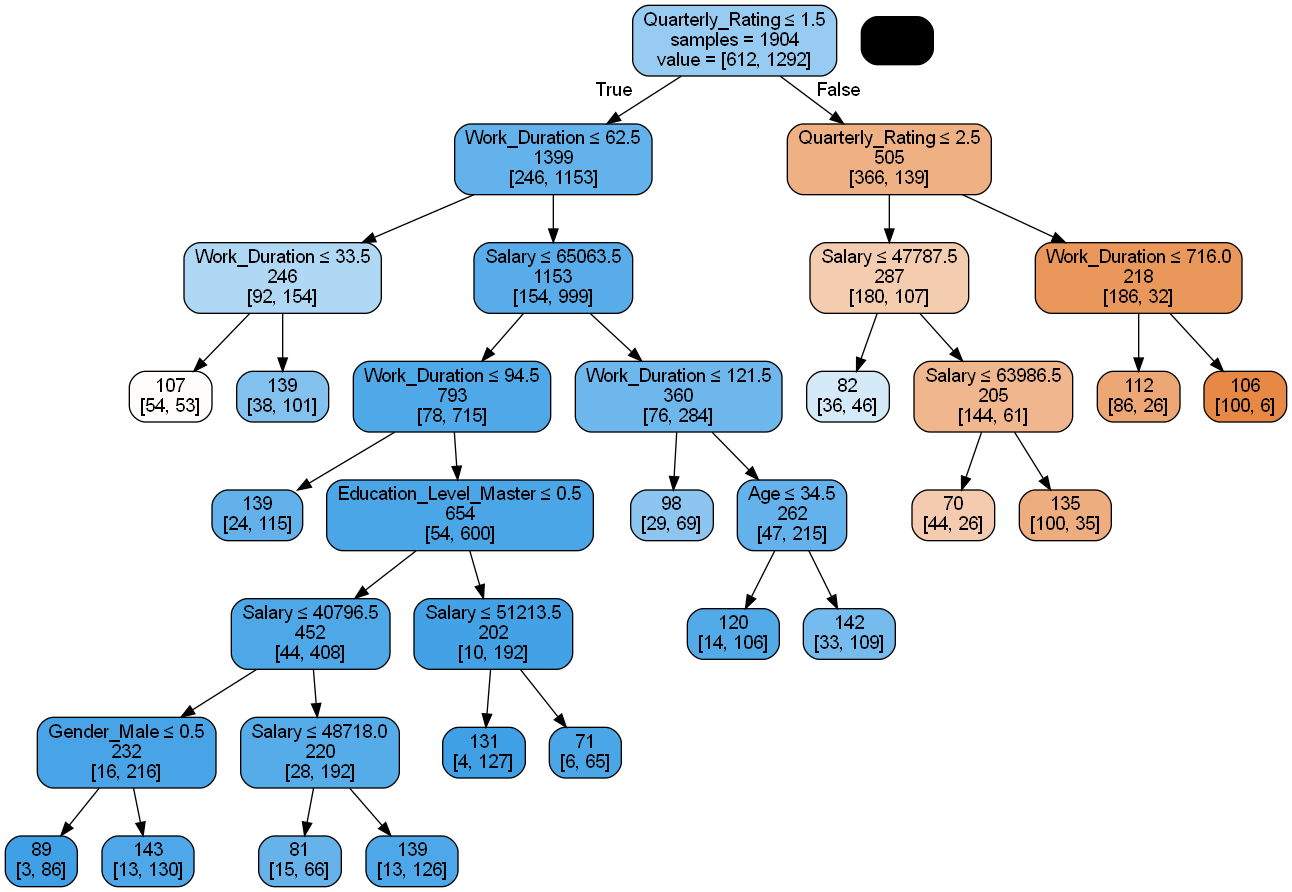

In [30]:
plotDecisionTree(model, feature_names = X_train.columns, pdfFile = FIG_PATH.joinpath("tree.pdf"))

## Using logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
model = train_test_model(lrc, X_train, y_train, X_test, y_test)

0.7714884696016772
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       153
           1       0.80      0.89      0.84       324

    accuracy                           0.77       477
   macro avg       0.74      0.70      0.72       477
weighted avg       0.76      0.77      0.76       477



In [32]:
# Start with an initial guess for parameters
param_grid = {
'penalty': ["none", "l1", "l2", "elasticnet"],
# 'tol': [20, 40, 60, 80, 100],
'C': [0.09, 0.1, 0.2, 0.3, 100, 1000]
}
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7699613206243956
Initial parameters:  {'C': 0.09, 'penalty': 'none'}


In [33]:
coefs = pd.DataFrame([X_train.columns, model.coef_[0]])

In [34]:
coefs = [list(X_train.columns), model.coef_[0]]
coef = pd.DataFrame(np.array(coefs).transpose())

In [35]:
print(coef.set_index(coef[0]).to_latex())

\begin{tabular}{lll}
\toprule
{} &                         0 &                       1 \\
0                        &                           &                         \\
\midrule
Age                      &                       Age &     0.09572743425219558 \\
Salary                   &                    Salary &  -7.938289986718062e-06 \\
Quarterly\_Rating         &          Quarterly\_Rating &     -1.4736019735250765 \\
Work\_Duration            &             Work\_Duration &  -0.0002197091366555691 \\
Gender\_Female            &             Gender\_Female &     0.03821909245966634 \\
Gender\_Male              &               Gender\_Male &     0.06578416649771512 \\
City\_C01                 &                  City\_C01 &    0.009342353299740149 \\
City\_C02                 &                  City\_C02 &     0.01822668518674396 \\
City\_C03                 &                  City\_C03 &   -0.008278324004347888 \\
City\_C04                 &                  City\_C04 &    0.01036

In [92]:
import statsmodels.api as sm

In [93]:
from util.dataset_manipulation import (get_dataset, create_additional_columns,
    clean_attrition_dataset, create_attrition, create_duration_of_work, create_salary_bins)

In [94]:
def create_categorical_variables(df: pd.DataFrame, create_dummies: bool = True) -> pd.DataFrame:
    '''Creates categorical variables for `Gender`, `City` and `Education_level`'''
    df.Gender = df.Gender.astype("category")
    df.City = df.City.astype("category")
    df.Education_Level = df.Education_Level.astype("category")
    df.delta_designation = df.delta_designation.astype("category")

    if create_dummies:
        df = pd.get_dummies(df, prefix_sep="_", drop_first=True)

    return df

In [95]:
df = get_dataset("train_data.csv")
df = clean_attrition_dataset(df)
df = create_additional_columns(df)
df = create_categorical_variables(df, True)
df = create_salary_bins(df)

In [96]:
X = df.drop(columns = ["Date", 
                            "Attrition", 
                            "Emp_ID", 
                            "Date_Of_Joining", 
                            "Last_Working_Date", 
                            "Joining_Designation", 
                            "Designation",
                            "Total_Business_Value",
                            # "Work_Duration",
                            # "Salary"
                            "salary_bin"
                            ]
                            )
y = df["Attrition"]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = 4259)

In [98]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.482335
         Iterations 6


In [99]:
print(log_reg.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}            &    Attrition     & \textbf{  No. Observations:  } &     1904    \\
\textbf{Model:}                    &      Logit       & \textbf{  Df Residuals:      } &     1865    \\
\textbf{Method:}                   &       MLE        & \textbf{  Df Model:          } &       38    \\
\textbf{Date:}                     & Wed, 09 Nov 2022 & \textbf{  Pseudo R-squ.:     } &   0.2319    \\
\textbf{Time:}                     &     10:36:14     & \textbf{  Log-Likelihood:    } &   -918.37   \\
\textbf{converged:}                &       True       & \textbf{  LL-Null:           } &   -1195.6   \\
\textbf{Covariance Type:}          &    nonrobust     & \textbf{  LLR p-value:       } & 6.202e-93   \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                   & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{Age}         

In [100]:
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))
  
# comparing original and predicted values of y
# print('Actual values', list(y_test.values))
# print('Predictions :', prediction)

In [101]:
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
  
# confusion matrix
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[ 74  79]
 [ 34 290]]
Test accuracy =  0.7631027253668763
